# First KNN with Keras

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'tensorflow'

We'll use the MNIST dataset of handwritten digits as our first example of applying an artificial neural network in Keras. keras.datasets provides several benchmark data sets such this one. We'll split into a train set of 59 000 images, a validation set of 1000 images, and a test set of 10 000 Images.

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_width = x_train.shape[1]
x_height = x_train.shape[2]
np.random.seed(2)

x_val = x_train[:999,...]
y_val = y_train[:999,...]

x_train = x_train[1000:,...]
y_train = y_train[1000:,...]

print("Train Data Shape", x_train.shape)
print("Train Label Shape ", y_train.shape)

Train Data Shape (59000, 28, 28)
Train Label Shape  (59000,)


The digits are represented as grey value images of 28x28 pixels as depicted below. Each pixel intensity is represented as 8 bit number ranging from 0 to 255.

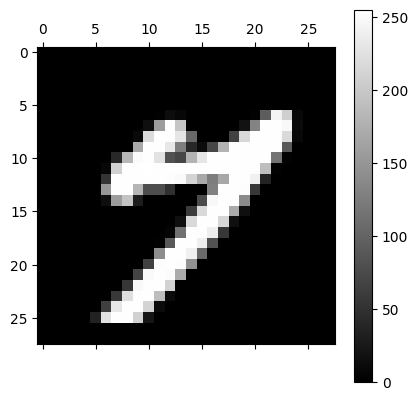

In [3]:
plt.matshow(x_train[1],cmap="gist_gray")
plt.colorbar()
plt.savefig("seven.png", dpi=200, bbox_inches="tight")
plt.show()

## Data Preperation

### One-Hot Ecnoding

The MNIST data set contains digits from 0 to 9 and hence has 10 classes. The label for each class is represented as an according integer from 0 to 9. In our first artificial neural network, each class is represented by an output neuron, yielding a one score for each class. In order to compare the output to the labels, the labels need to be one-hot encoded. This means for each label entry, an array is generated with an length equal to the number of classes. Each entry is zero but the one corresponding to the class

In [4]:
print("Label representation as integer:", y_train[1])

n_classes = len(np.unique(y_train))
one_hot_tensor = tf.one_hot(y_train[1], depth=n_classes)
print("Label representation as one-hot tensor:", one_hot_tensor)

Label representation as integer: 7
Label representation as one-hot tensor: tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)


The one-hot encoding is one of several steps in the data pipeline. Data pipelines can be implemented using the tf.data module. In the following steps several preprocessing functions are defined.

In [5]:
# For efficiency, the function used here are wrapped as tf.function objects using the respective decorator
@tf.function
def normalize_img(data, label):
    # it is essential to scale the data. Since each pixel is represented by a 8 bit integer, we'll divide by 255 to normalize the pixel values to [0,1]
    return tf.cast(data, tf.float32) / 255., label
    
@tf.function
def one_hot_encoding(data, label):
    # Performing the one-hot encoding using the tesnorflow function demonstrated above
    one_hot_labels = tf.one_hot(label, depth=n_classes)
    return data, one_hot_labels

# defining the training data pipe line
# first a Dataset object is initialised using the training data and labels from tensor slices
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Using the Dataset.map function, the predefined preprocessing steps can be applied efficiently to each data entry
dataset_train = dataset_train.map(normalize_img)
dataset_train = dataset_train.map(one_hot_encoding)
# The data set is cached to increase performance
dataset_train = dataset_train.cache()
# after each epoch, the data set is randomly shuffled to decrease overfitting
dataset_train = dataset_train.shuffle(x_train.shape[0])
# the data set is divided into batches of 64
dataset_train = dataset_train.batch(64)
# during the evaluation at the end of each epoch the next batch is already prefetched to increase performance
dataset_train = dataset_train.prefetch(tf.data.AUTOTUNE)

# Validation and test data sets are prepared similarly but they don't have to be shuffled, since they're not used for weight updates
dataset_val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
dataset_val = dataset_val.map(normalize_img)
dataset_val = dataset_val.map(one_hot_encoding)
dataset_val = dataset_val.batch(64)
dataset_val = dataset_val.cache()
dataset_val = dataset_val.prefetch(tf.data.AUTOTUNE)

dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
dataset_test = dataset_test.map(normalize_img)
dataset_test = dataset_test.map(one_hot_encoding)
dataset_test = dataset_test.batch(64)
dataset_test = dataset_test.cache()
dataset_test = dataset_test.prefetch(tf.data.AUTOTUNE)

## Building a Model

An artifical neural network can be set up using keras.layers. Each layer output is used as input for the following layer hence generating some thing similar to multi-layer-perceptron

In [6]:
# the input layer is defined by the expected input shape of the data.
input_layer = tf.keras.layers.Input(shape=(x_width, x_height), name="input_layer")
# since we're using 2D data we'll reshape the input into a vector of size 28x28 = 784 dimensions
flatten = tf.keras.layers.Flatten(name="flatten")(input_layer)
# The Dense layer corresponds to the layers used in the multi-layer-perceptron. Each neuron is connected to each input, hence the name
# The number of artificial neurons in the layer is defined by the units-parameter, and for the activation function we choose the sigmoid
hidden_layer = tf.keras.layers.Dense(units=32,
                                    activation="sigmoid",
                                    name="hidden_layer")(flatten)
# Another Dense layer is used as output. It consists of 10 neurons with sigmoid activation. Each neuron represents an output class and yields a score from 0 to 1
# The neuron with the highest score is selected as output class. The objective of the training is to get this result vector as close to the one-hot label vector as possible
output_layer = tf.keras.layers.Dense(units=10,
                                    activation="sigmoid",
                                    name="output_layer")(hidden_layer)

## Compiling the model

In [7]:
# A keras.Model can be defined by specifying the input and the output vectors of the neural network assembled above
model = tf.keras.Model(inputs=input_layer, outputs=[output_layer])
# The model needs to be compiled for the training. The most important parameters for the compilation are
# the optimizer, the loss function and the accuracy metric.
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(0.2), # RMSprop of SGD wechsel 
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])
# The Model.summary returns some helpful information concerning the model architecture and sizes
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden_layer (Dense)        (None, 32)                25120     
                                                                 
 output_layer (Dense)        (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


## Training the Model

After the data pipeline is configured and the model ist constructed and compile, the training can be performed

In [ ]:
# The training can be performed using the Model.fit method. Most importantly the train and 
# validation data sets are specified, and for example the maximum number of training epochs.
# Further options will be explored later during the course
history = model.fit(
    dataset_train,
    validation_data=dataset_val,
    epochs=10
    )
# The model can be saved in several file formats after training for deployment or further training
model.save("./first_model.h5")

Epoch 1/10
922/922 [==============================] - 3s 1ms/step - loss: 0.1009 - categorical_accuracy: 0.1000 - val_loss: 0.1000 - val_categorical_accuracy: 0.0931
Epoch 2/10
264/922 [=======>......................] - ETA: 0s - loss: 0.1000 - categorical_accuracy: 0.0987

## Analyzing the Metrics

Training and validation metrics are important to monitor the model performance during the training process. It can point towards several problems such as overfitting or instability. 

In [ ]:
print("The history contains the metrics' progress along the training:", history.history.keys())
fig, ax1 = plt.subplots()

ax1.plot(history.epoch, history.history["loss"], label="Training Loss", c="#266662", linestyle="--")
ax1.plot(history.epoch, history.history["val_loss"], label="Valdation Loss", c="#ED5654", linestyle="--")
ax2 = ax1.twinx()
ax2.plot(history.epoch, history.history["categorical_accuracy"], c="#266662", label="Training Accuracy")
ax2.plot(history.epoch, history.history["val_categorical_accuracy"], c="#ED5654", label="Validation Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Accuracy")
fig.legend(loc="center")
plt.show()

## Evaluate on Test Data

An important step in the life cycle of a model is the evaluation on a test set. Before the model is deployed, it is important to make sure it performs as expected on a given test set.

In [ ]:
test_prediction = model.evaluate(dataset_test)
print("Test Loss: ", test_prediction[0])
print("Test Accuracy: ", test_prediction[1])

## Understanding the Model

To understand the model in a bit more detail, we'll take a look inside. To that end, an example batch is extracted from the training data and predicted by the model.

In [ ]:
example_data = dataset_train.as_numpy_iterator()
example_batch = example_data.next()[0]
example_batch.shape

As described above, the model predicts a score for each of the ten output classes. The class with the highest output score (as calculated by a sigmoid function) can be extraced by an argmax function and is declared the classification result.

In [ ]:
prediction = model.predict(example_batch)
print("The prediction result looks the following:\n", prediction[0])

plt.matshow(example_batch[0], cmap="gist_gray")
plt.title(f"Class {np.argmax(prediction[0])} with sigmoid score of {np.max(prediction[0]):.2f}")
plt.colorbar()
plt.show()

The model inference can be inspected more closely by adding each layers output to the model output for each inference

In [ ]:
# all layer outputs are added to the model output
multi_out = tf.keras.Model(inputs=model.input, outputs=[layer.output for layer in model.layers])
# the predict call now returns all specified outputs
all_outputs = multi_out.predict(example_batch)

The Flatten layer transforms the 2D input image into a 1D vector. For now we can only deal with vectors as inputs

In [ ]:
# the following entry in the output list is the the output after the Flatten layer transforming the 28x28 pixels into a 784 parameter vector.
# Each prediction is performed in batches of 64, hence, the first dimension (all_outputs[1].shape[0]) of each output is number of data samples in each batch
print("Shape after flattening layer:", all_outputs[1].shape)
plt.figure(figsize=(16, 4))
plt.bar(range(all_outputs[1].shape[1]), all_outputs[1][0,:], color="#266662")
plt.savefig("flattened_in.png", dpi=200, bbox_inches="tight")
plt.show()

In [ ]:
#The hidden layer processes these 784 inputs and calculates 64 outputs from them
hidden_out = all_outputs[2]
print("Output Shape of hidden layer:", hidden_out.shape)
plt.figure(figsize=(16, 4))
plt.bar(range(hidden_out.shape[1]), hidden_out[0,:], color="#266662")
plt.xlabel("Output Number")
plt.ylabel("Activation Strength")
plt.show()

## Feature Embedding with PCA

Since it's difficut to develop an intuitiion for such high dimensional feature spaces, a representation of the first two principal components can help

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
example_batch_2D = pca.fit_transform(hidden_out)
pca.explained_variance_ratio_

Each image can now be embedded into the two dimensional space. Indeed, the different input classes are projected onto different regions of the feature space. This is an indication that the hidden layer arranges the data reasonably for the classification afterwards

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def imscatter(x, y, images, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    digits = list()
    for x0, y0, im in zip(x, y, images):
        im = OffsetImage(im, zoom=zoom, cmap="gist_gray")
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        digits.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return digits
    
fig, ax = plt.subplots()
imscatter(example_batch_2D[:, 0],
          example_batch_2D[:, 1],
          example_batch,
          zoom=0.5,
          ax=ax)
ax.set_xlabel("1st Main Component")
ax.set_ylabel("2nd Main Component")
plt.show()